In [1]:
from torchvision.datasets import CIFAR10
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision import transforms
import PIL
from models.predefined import InstanceDependentNoiseAdder
from models.utils import set_global_seed
set_global_seed(42)

In [41]:
def plot_tsne(X, y, noise_ratio):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 8))
    tsne = TSNE(n_components=2, perplexity=5, max_iter=1000, random_state=42)
    X_tsne = tsne.fit_transform(X)

    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.7,
                         edgecolors='white', s=80)
    cbar = plt.colorbar(scatter, ticks=range(10), ax=ax)
    cbar.ax.set_yticklabels(range(10))
    ax.set_title(f"t-SNE Visualization of CIFAR10 with Noise Ratio {noise_ratio}", fontsize=16)
    ax.set_xlabel("t-SNE Component 1", fontsize=14)
    ax.set_ylabel("t-SNE Component 2", fontsize=14)
    plt.tight_layout()
    plt.show()

In [42]:
def get_image_size(dataset):
    sample, _ = dataset[0]
    if isinstance(sample, PIL.Image.Image):
        sample = transforms.ToTensor()(sample)
    return sample.shape[0] * sample.shape[1] * sample.shape[2]

Files already downloaded and verified


<Figure size 1000x800 with 0 Axes>

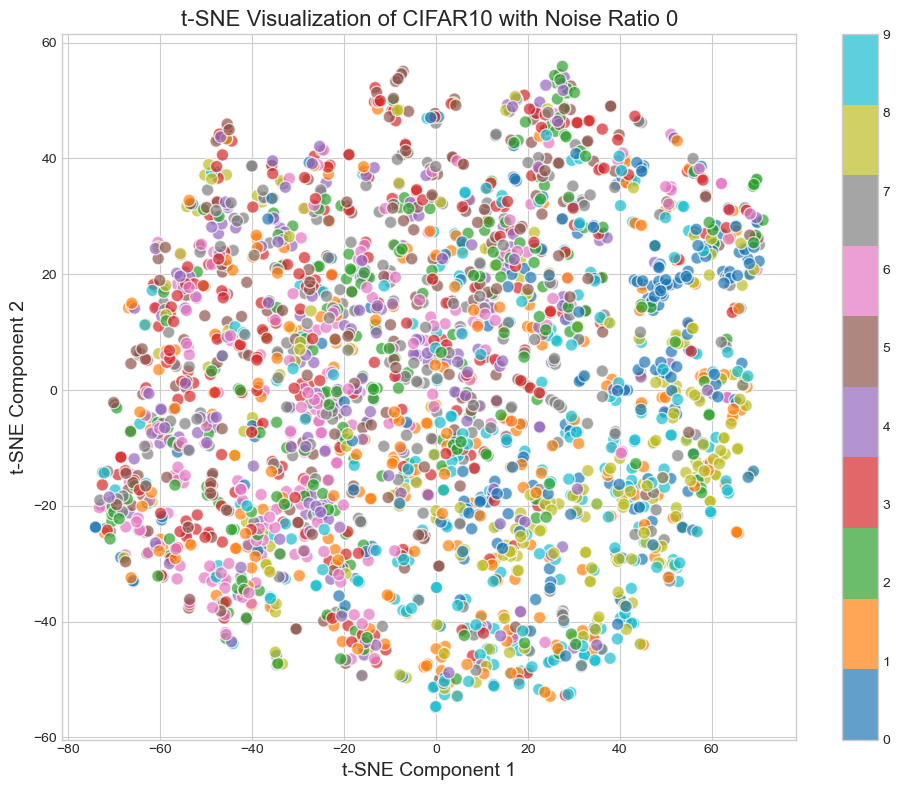

In [43]:
cifar10 = CIFAR10(root='./data', train=True, download=True)

n_total = cifar10.data.shape[0]
n_sample = n_total // 20
sample_indices = np.random.choice(n_total, size=n_sample, replace=False)

X = cifar10.data[sample_indices].reshape(n_sample, -1)
y = np.array(cifar10.targets)[sample_indices]
plot_tsne(X, y, 0)

Files already downloaded and verified
Seed: 94


<Figure size 1000x800 with 0 Axes>

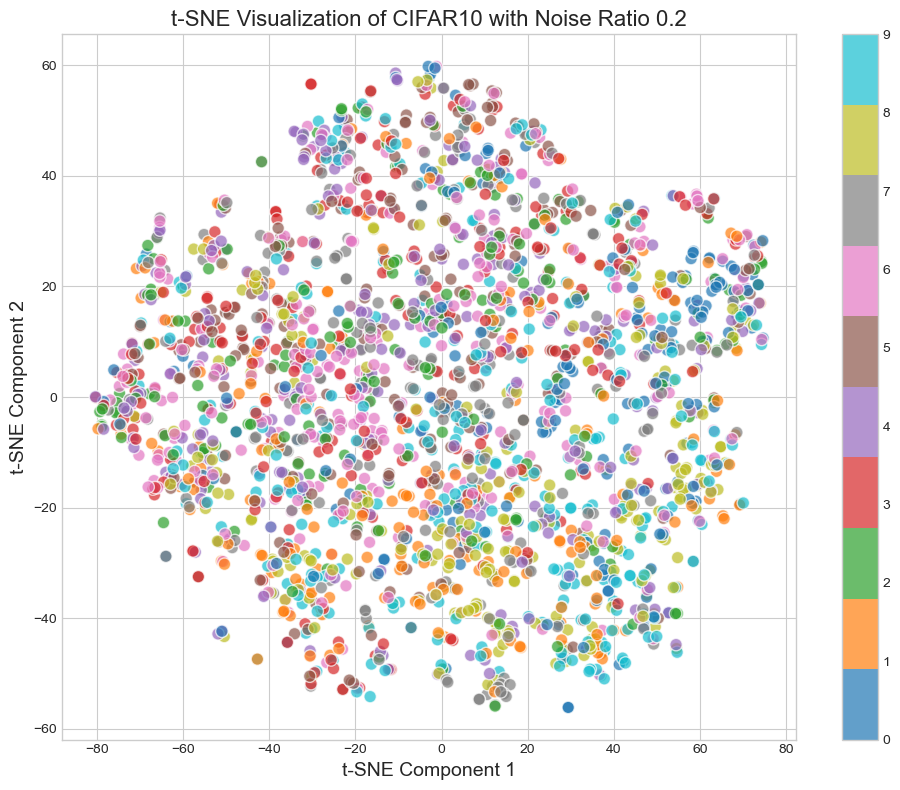

In [44]:
dataset = CIFAR10(root='./data', train=True, download=True)
image_size = get_image_size(dataset)
train_noise_adder = InstanceDependentNoiseAdder(dataset, image_size=image_size, ratio=0.2, num_classes=10)
train_noise_adder.add_noise()

n_total = dataset.data.shape[0]
n_sample = n_total // 20
sample_indices = np.random.choice(n_total, size=n_sample, replace=False)

X = dataset.data[sample_indices].reshape(n_sample, -1)
y = np.array(dataset.targets)[sample_indices]
plot_tsne(X, y, 0.2)

Files already downloaded and verified
Seed: 88


<Figure size 1000x800 with 0 Axes>

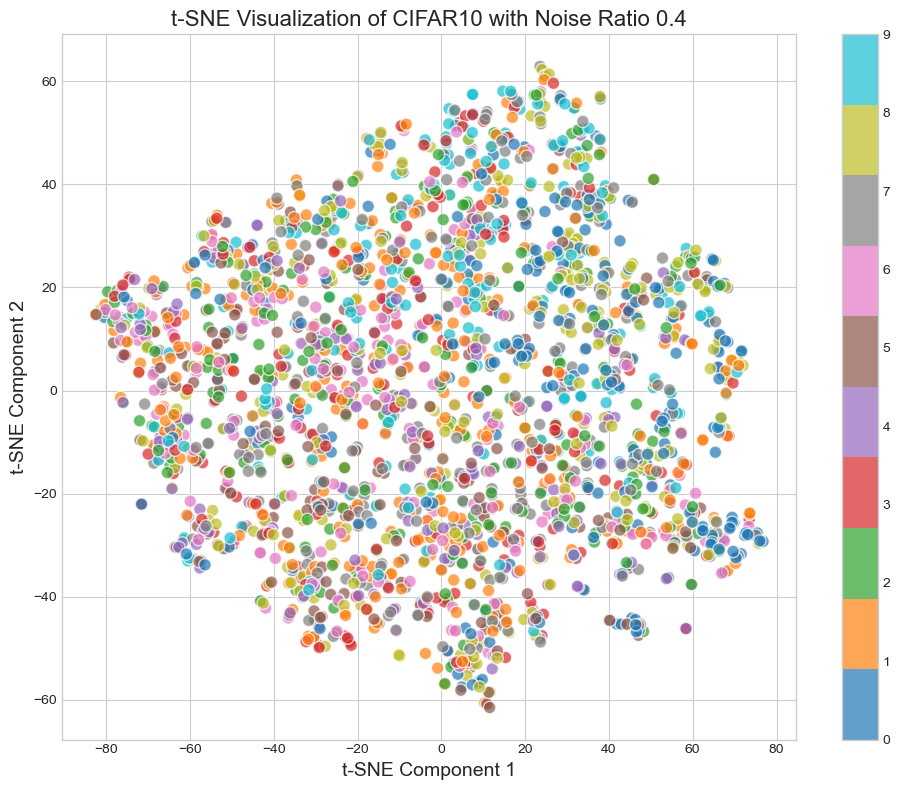

In [45]:
dataset = CIFAR10(root='./data', train=True, download=True)
image_size = get_image_size(dataset)
train_noise_adder = InstanceDependentNoiseAdder(dataset, image_size=image_size, ratio=0.4, num_classes=10)
train_noise_adder.add_noise()

n_total = dataset.data.shape[0]
n_sample = n_total // 20
sample_indices = np.random.choice(n_total, size=n_sample, replace=False)

X = dataset.data[sample_indices].reshape(n_sample, -1)
y = np.array(dataset.targets)[sample_indices]
plot_tsne(X, y, 0.4)

Files already downloaded and verified
Seed: 69


<Figure size 1000x800 with 0 Axes>

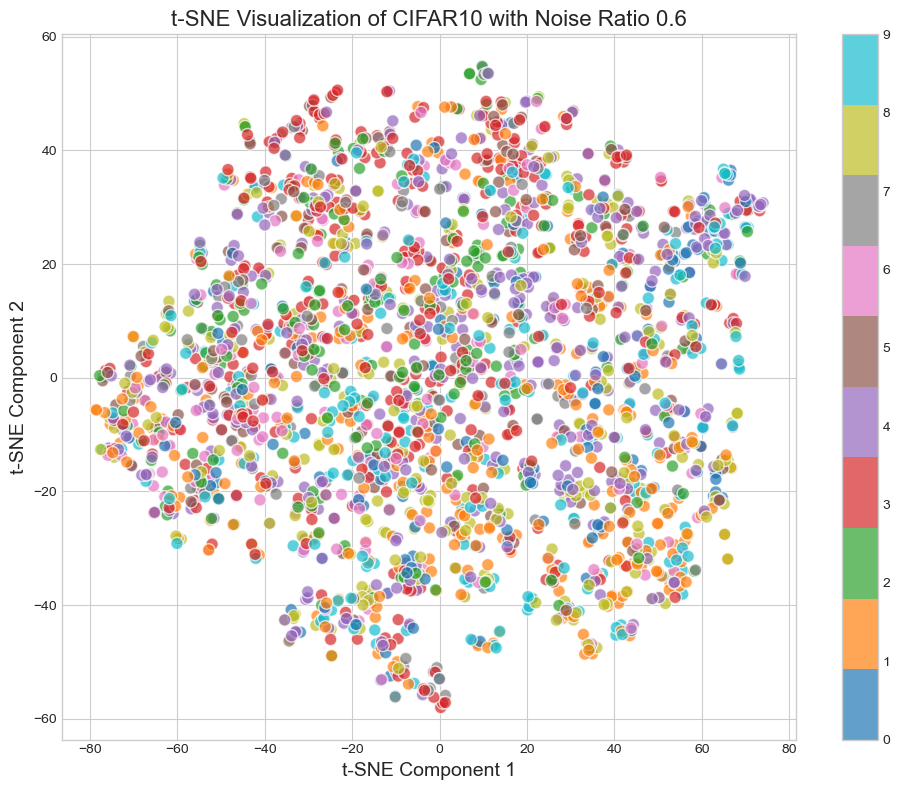

In [46]:
dataset = CIFAR10(root='./data', train=True, download=True)
image_size = get_image_size(dataset)
train_noise_adder = InstanceDependentNoiseAdder(dataset, image_size=image_size, ratio=0.6, num_classes=10)
train_noise_adder.add_noise()

n_total = dataset.data.shape[0]
n_sample = n_total // 20
sample_indices = np.random.choice(n_total, size=n_sample, replace=False)

X = dataset.data[sample_indices].reshape(n_sample, -1)
y = np.array(dataset.targets)[sample_indices]
plot_tsne(X, y, 0.6)